In [156]:
library("brms")
library("dplyr")
library("bayesplot")
library("rstanarm")
library("ggplot2")
library("rstan")
library("tidyr")
library("ggpubr")
library("projpred")
library("corrplot")
library("loo")
library("tidyverse")
library("here")
library("knitr")
library("walker")
library("tidybayes")
library("broom")
library("ggridges")
# library("cmdstanr")
library("reshape2")
library("lubridate")
library("hrbrthemes")
library("viridis")
library('ggthemes')
library(scales)
options(repr.plot.width=10, repr.plot.height=10)

This model is based on data taken from Figure 3 
https://reader.elsevier.com/reader/sd/pii/S0167577X20315433?token=661728B0466FC76D2003CC4F6314E8EEC5DB8C7E6BE4B1B7983DC00392689F48C68839CEBD1E35A55AC0B5936308FA1F
showing measurements for shear strength and surface roughness for silica cold joined with an instoatic pressure of 300 MPa, and with no pressure applied.

In [3]:
df1=data.frame("roughness" = c(0.05,0.1,1.7,3.1),
              "shearStrength"=c(17.8,15.2,10,9.5),
              "shearStrengthU"=c(17.8+3,15.2+3,10+2,9.5+3),
              "shearStrengthL"=c(17.8-3,15.2-3,10-2,9.5-3),
              "pressure"=c(0,0,0,0)
          )
df2=data.frame("roughness" = c(0.05,0.1,1.7,3.1),
              "shearStrength"=c(12.5,9,8.5,8),
              "shearStrengthU"=c(12.5+1.5,9+2,8.5+1,8+1.5),
              "shearStrengthL"=c(12.5-1.5,9-2,8.5-1,8-1.5),
              "pressure"=c(300,300,300,300)
          )
df = rbind(df1,df2)

In [4]:
sqrt(mean((df1$shearStrengthU - df1$shearStrengthL) + (df1$shearStrengthU - df1$shearStrengthL))/6)

[1] 1.354006

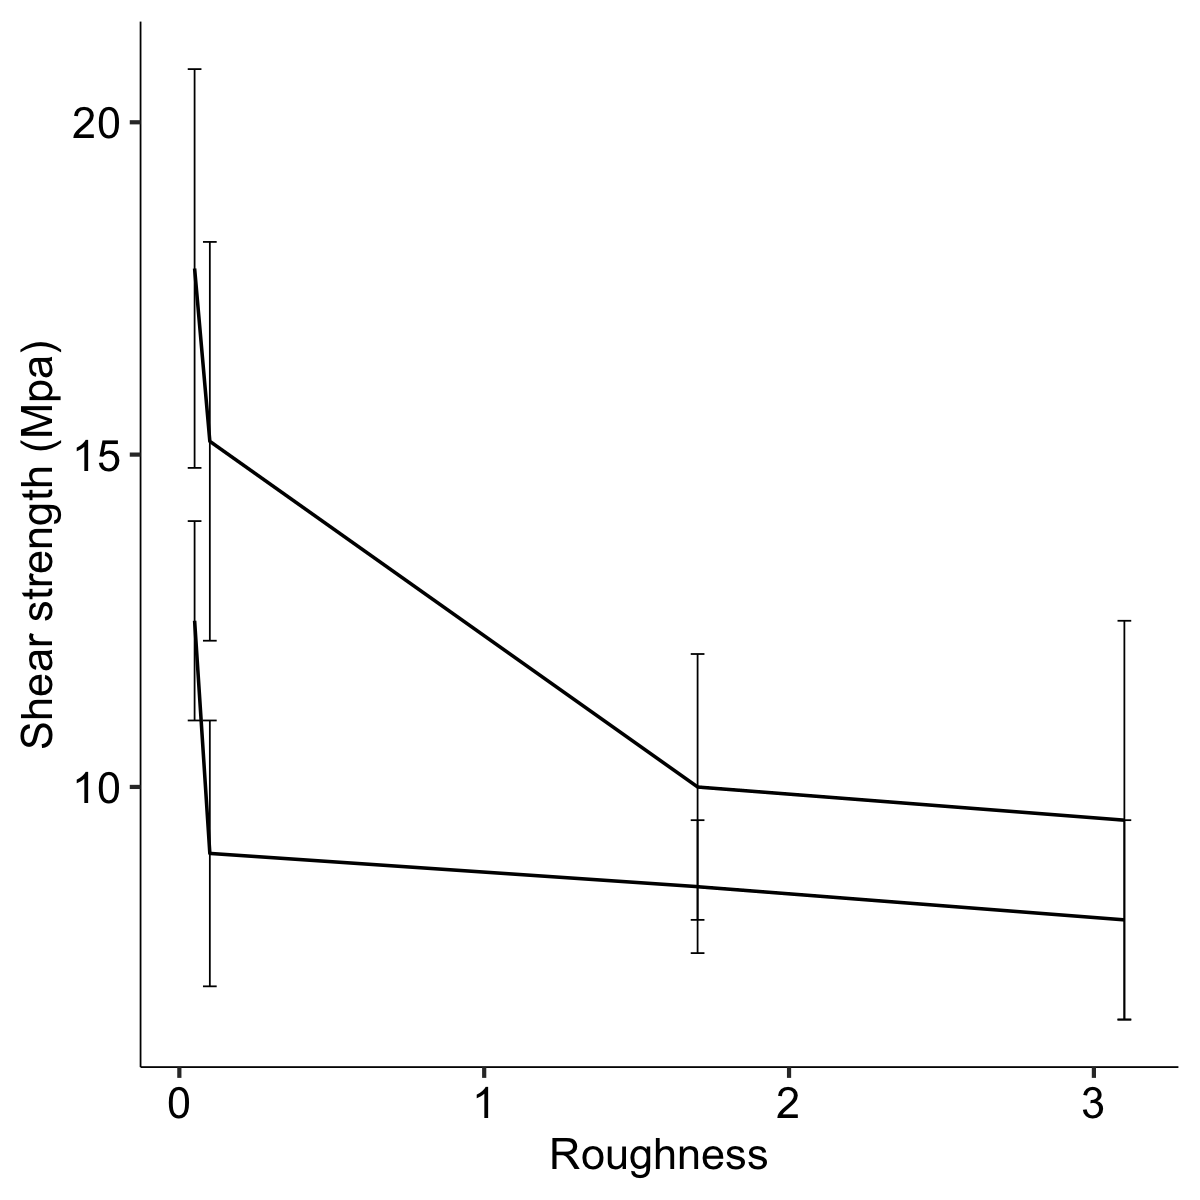

In [5]:
ggplot(data=df) + geom_line(aes(x=roughness,y=shearStrength,group=pressure),size=1)+
    geom_errorbar(aes(x=roughness, ymin=shearStrengthL, ymax=shearStrengthU))+
    xlab("Roughness")+ ylab("Shear strength (Mpa)")+
    theme_pubr(26)

### Model 1

Compiling Stan program...

recompiling to avoid crashing R session

Start sampling

Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#bulk-ess”


Estimate  Est.Error Q2.5      Q97.5    roughness shearStrength shearStrengthU
1 16.757631 1.300980  14.209774 19.27344 0.05      17.8          20.8          
2 16.162868 1.233736  13.772478 18.58794 0.10      15.2          18.2          
3  9.795513 1.354596   7.289770 12.56506 1.70      10.0          12.0          
4  8.861094 1.201487   6.430222 11.20695 3.10       9.5          12.5          
5 11.010039 1.738252   7.864229 14.42415 0.05      12.5          14.0          
6  9.642558 1.247560   7.167006 12.19681 0.10       9.0          11.0          
7  9.189113 1.250197   6.761517 11.64133 1.70       8.5           9.5          
8  9.192350 1.224238   6.853177 11.50140 3.10       8.0           9.5          
  shearStrengthL pressure
1 14.8             0     
2 12.2             0     
3  8.0             0     
4  6.5             0     
5 11.0           300     
6  7.0           300     
7  7.5           300     
8  6.5           300

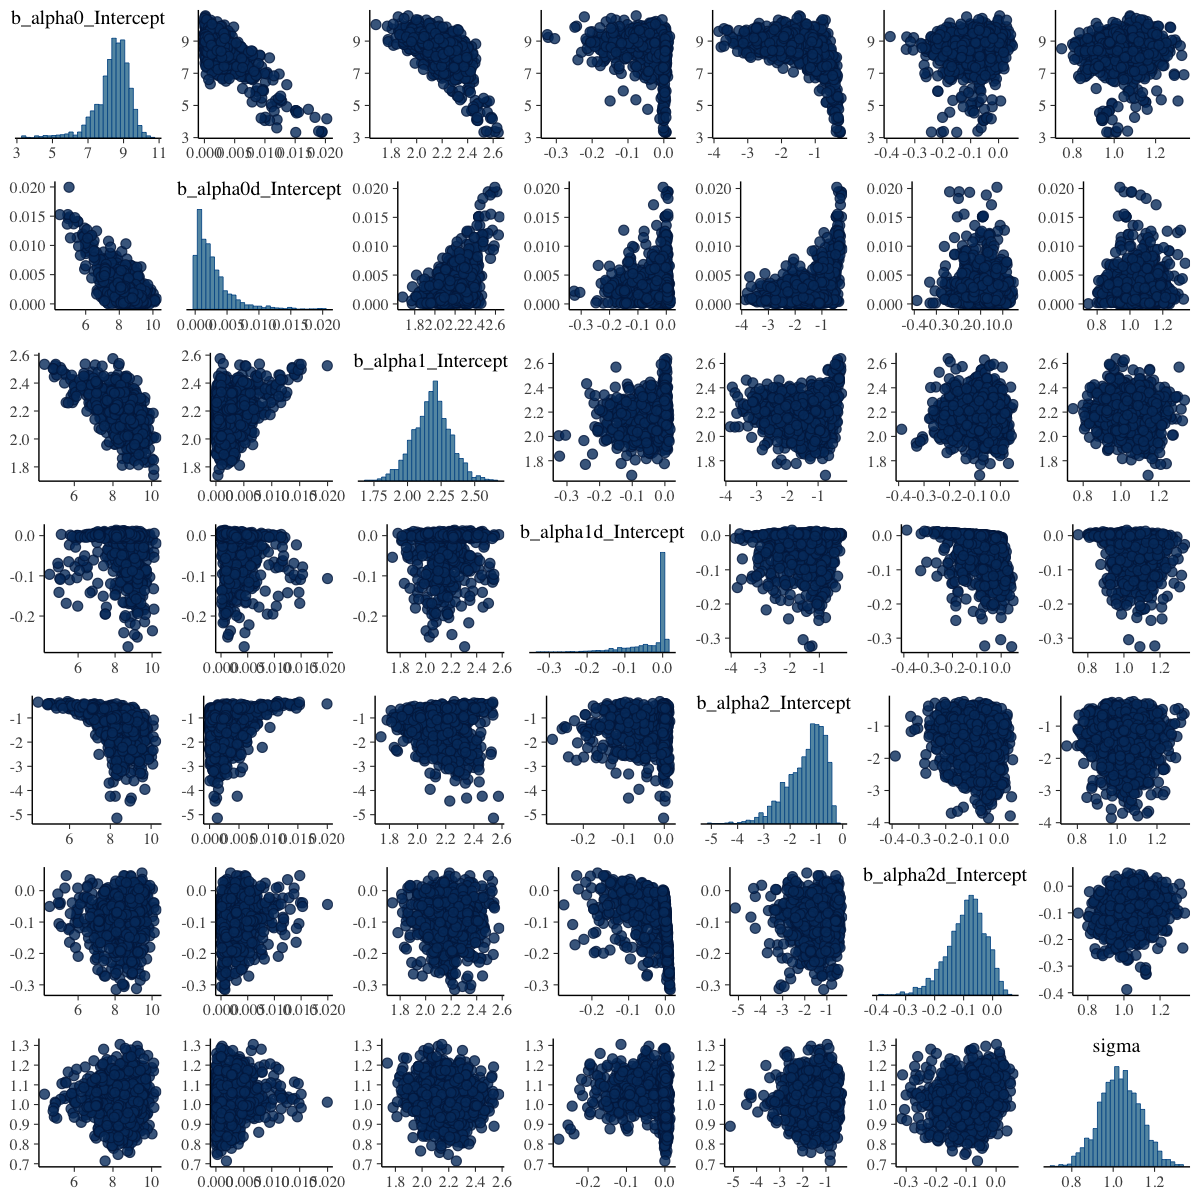

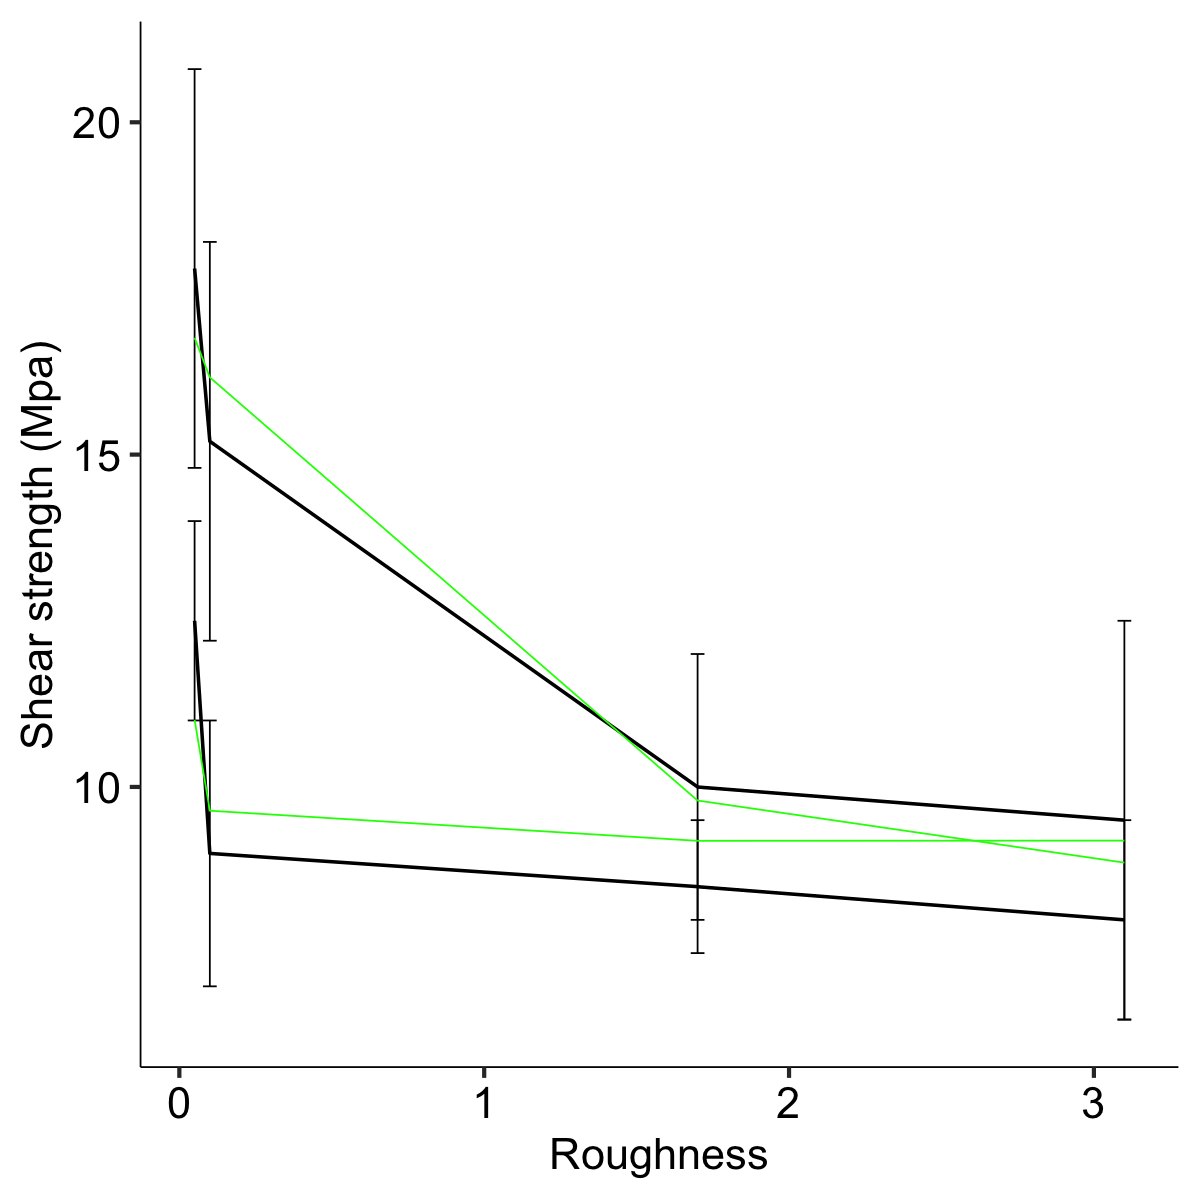

In [100]:
prior1 <- prior(normal(1, 0.1), class = "sigma") +
          prior(normal(10, 3), nlpar = "alpha0", lb=0) +
          prior(normal(0, 0.1), nlpar = "alpha0d", lb=0) +
          prior(normal(2, 2), nlpar = "alpha1") +
          prior(normal(0, 0.1), nlpar = "alpha1d") +
          prior(normal(-1, 1), nlpar = "alpha2",ub=0) + 
          prior(normal(0, 0.1), nlpar = "alpha2d")
fit <- brm(
        bf(shearStrength ~ ((alpha0 + alpha0d * pressure) + 
                            exp( (alpha1 + alpha1d * pressure) + 
                            (alpha2 + alpha2d * pressure) * pow(roughness,1))),
        alpha0 + alpha0d + alpha1 + alpha1d + alpha2 + alpha2d ~ 1, 
        nl = TRUE),
        data = df, 
        prior=prior1,
        iter=2000,
        chains = 2,
        cores = 2,
        seed = 8888,
        control = list(adapt_delta = 0.9),
        refresh = 0
)
pairs(fit)

preds=cbind(predict(fit,newdata=df),df)
preds

ggplot(data=preds) + geom_line(aes(x=roughness,y=shearStrength,group=pressure),size=1)+
    geom_errorbar(aes(x=roughness, ymin=shearStrengthL, ymax=shearStrengthU))+
    xlab("Roughness")+ ylab("Shear strength (Mpa)")+
    theme_pubr(26) +
    geom_line(aes(x=roughness, y=Estimate,group=pressure),col="Green")

### Model 2 

Compiling Stan program...

Start sampling

Warning message:
“There were 180 divergent transitions after warmup. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”


Estimate  Est.Error Q2.5      Q97.5    roughness shearStrength shearStrengthU
1 16.792432 1.283807  14.328571 19.23598 0.05      17.8          20.8          
2 16.144224 1.255397  13.707954 18.62789 0.10      15.2          18.2          
3 10.045275 1.262355   7.521338 12.55409 1.70      10.0          12.0          
4  9.352769 1.243325   6.850538 11.79397 3.10       9.5          12.5          
5 10.816542 1.227526   8.481196 13.26537 0.05      12.5          14.0          
6 10.734116 1.241503   8.338634 13.21453 0.10       9.0          11.0          
7  9.057087 1.182747   6.766450 11.26945 1.70       8.5           9.5          
8  7.649569 1.372524   4.930535 10.33060 3.10       8.0           9.5          
  shearStrengthL pressure
1 14.8             0     
2 12.2             0     
3  8.0             0     
4  6.5             0     
5 11.0           300     
6  7.0           300     
7  7.5           300     
8  6.5           300

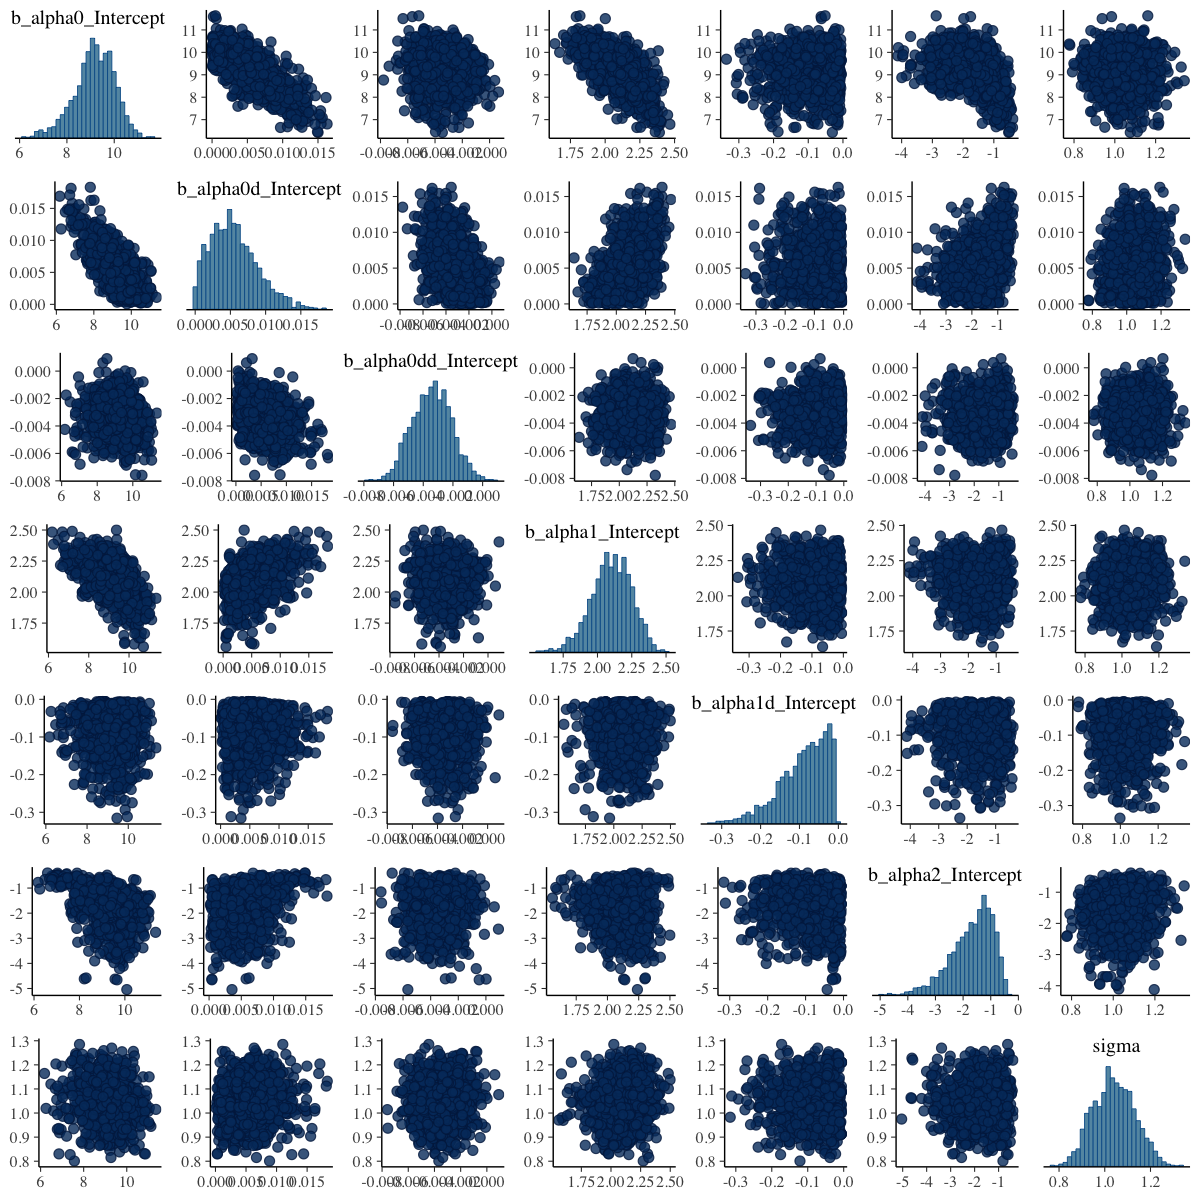

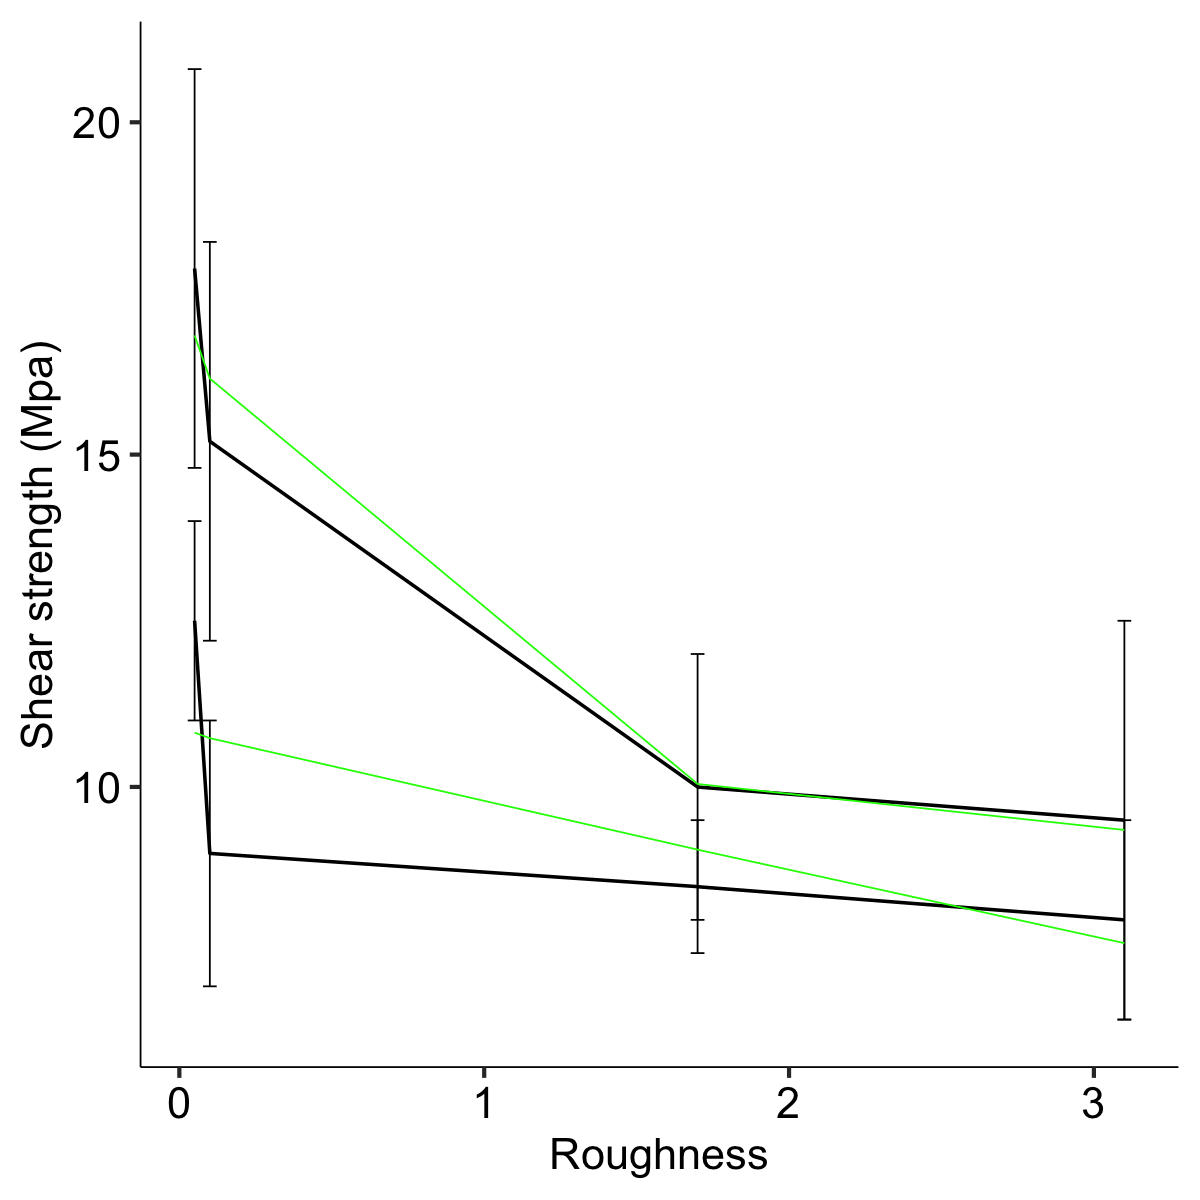

In [102]:
prior1 <- prior(normal(1, 0.1), class = "sigma") +
          prior(normal(10, 3), nlpar = "alpha0", lb=0) +
          prior(normal(0, 0.1), nlpar = "alpha0d", lb=0) +
          prior(normal(0, 0.1), nlpar = "alpha0dd") +
          prior(normal(2, 2), nlpar = "alpha1") +
          prior(normal(0, 0.1), nlpar = "alpha1d") +
          prior(normal(-1, 1), nlpar = "alpha2",ub=0)
fit <- brm(
        bf(shearStrength ~ ((alpha0 + alpha0d * pressure+ alpha0dd * pressure * roughness) + 
                            exp( (alpha1 + alpha1d * pressure) + 
                            (alpha2) * pow(roughness,1))),
        alpha0 + alpha0d + alpha0dd + alpha1 + alpha1d + alpha2 ~ 1, 
        nl = TRUE),
        data = df, 
        prior=prior1,
        iter=2000,
        chains = 2,
        cores = 2,
        seed = 8888,
        control = list(adapt_delta = 0.9),
        refresh = 0
)
pairs(fit)

preds=cbind(predict(fit,newdata=df),df)
preds

ggplot(data=preds) + geom_line(aes(x=roughness,y=shearStrength,group=pressure),size=1)+
    geom_errorbar(aes(x=roughness, ymin=shearStrengthL, ymax=shearStrengthU))+
    xlab("Roughness")+ ylab("Shear strength (Mpa)")+
    theme_pubr(26) +
    geom_line(aes(x=roughness, y=Estimate,group=pressure),col="Green")

### Model 3

Compiling Stan program...

Start sampling



Estimate  Est.Error Q2.5      Q97.5    roughness shearStrength shearStrengthU
1 16.725869 1.246079  14.319109 19.21947 0.05      17.8          20.8          
2 16.171683 1.238514  13.794811 18.54904 0.10      15.2          18.2          
3  9.919604 1.277254   7.440208 12.44156 1.70      10.0          12.0          
4  9.119742 1.193004   6.670149 11.37497 3.10       9.5          12.5          
5 11.828674 1.210723   9.394269 14.30044 0.05      12.5          14.0          
6 10.298626 1.186493   8.023533 12.67432 0.10       9.0          11.0          
7  8.726823 1.137888   6.509282 11.03690 1.70       8.5           9.5          
8  7.833169 1.368765   5.053746 10.43752 3.10       8.0           9.5          
  shearStrengthL pressure
1 14.8             0     
2 12.2             0     
3  8.0             0     
4  6.5             0     
5 11.0           300     
6  7.0           300     
7  7.5           300     
8  6.5           300

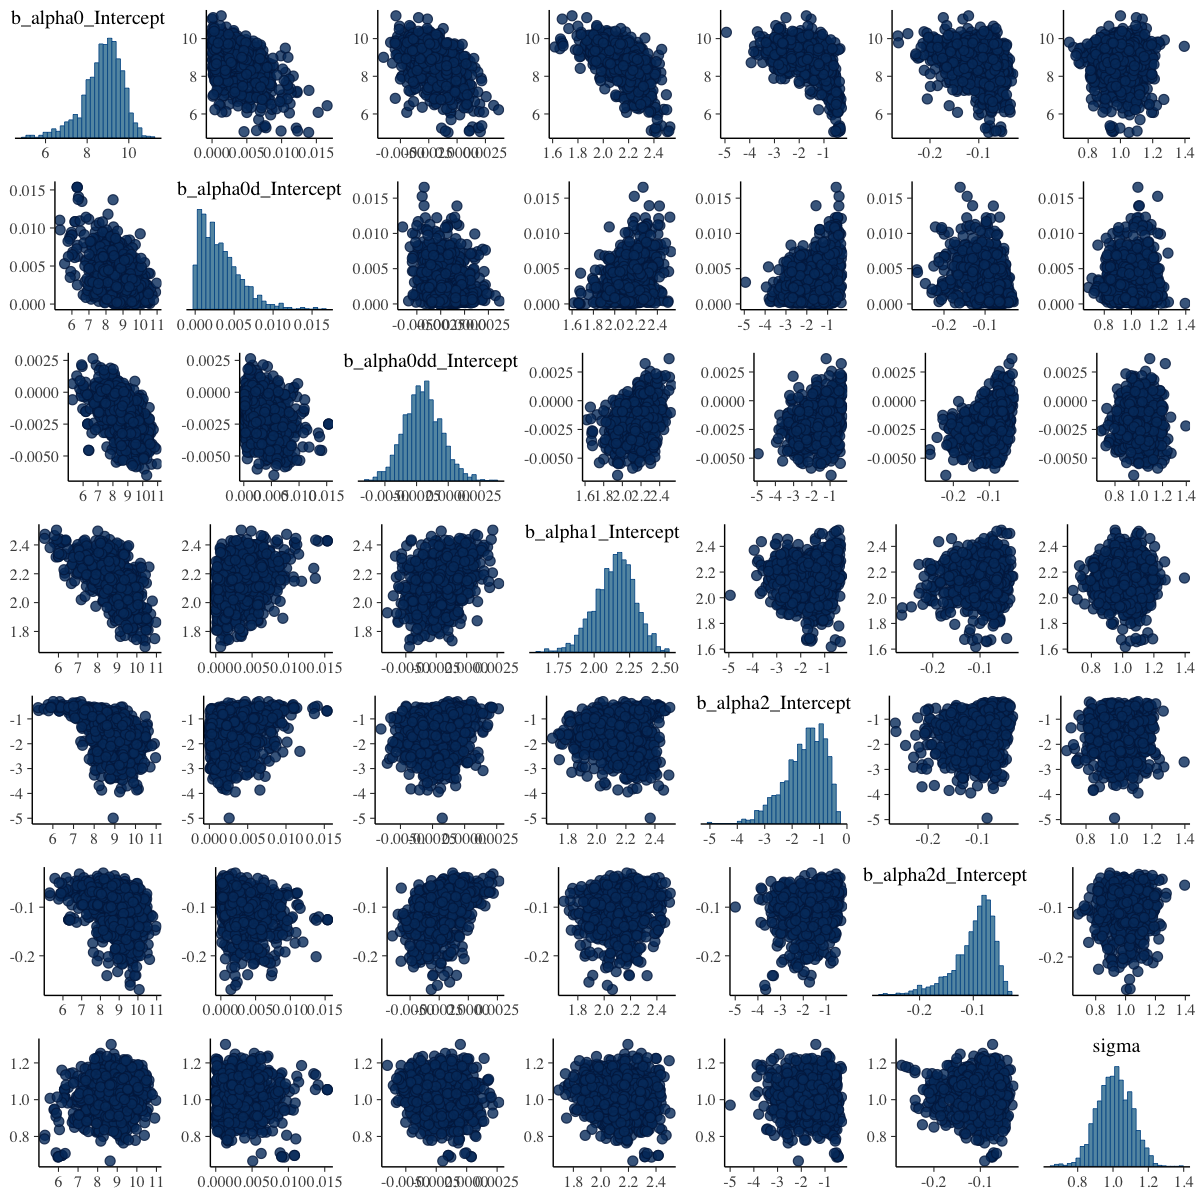

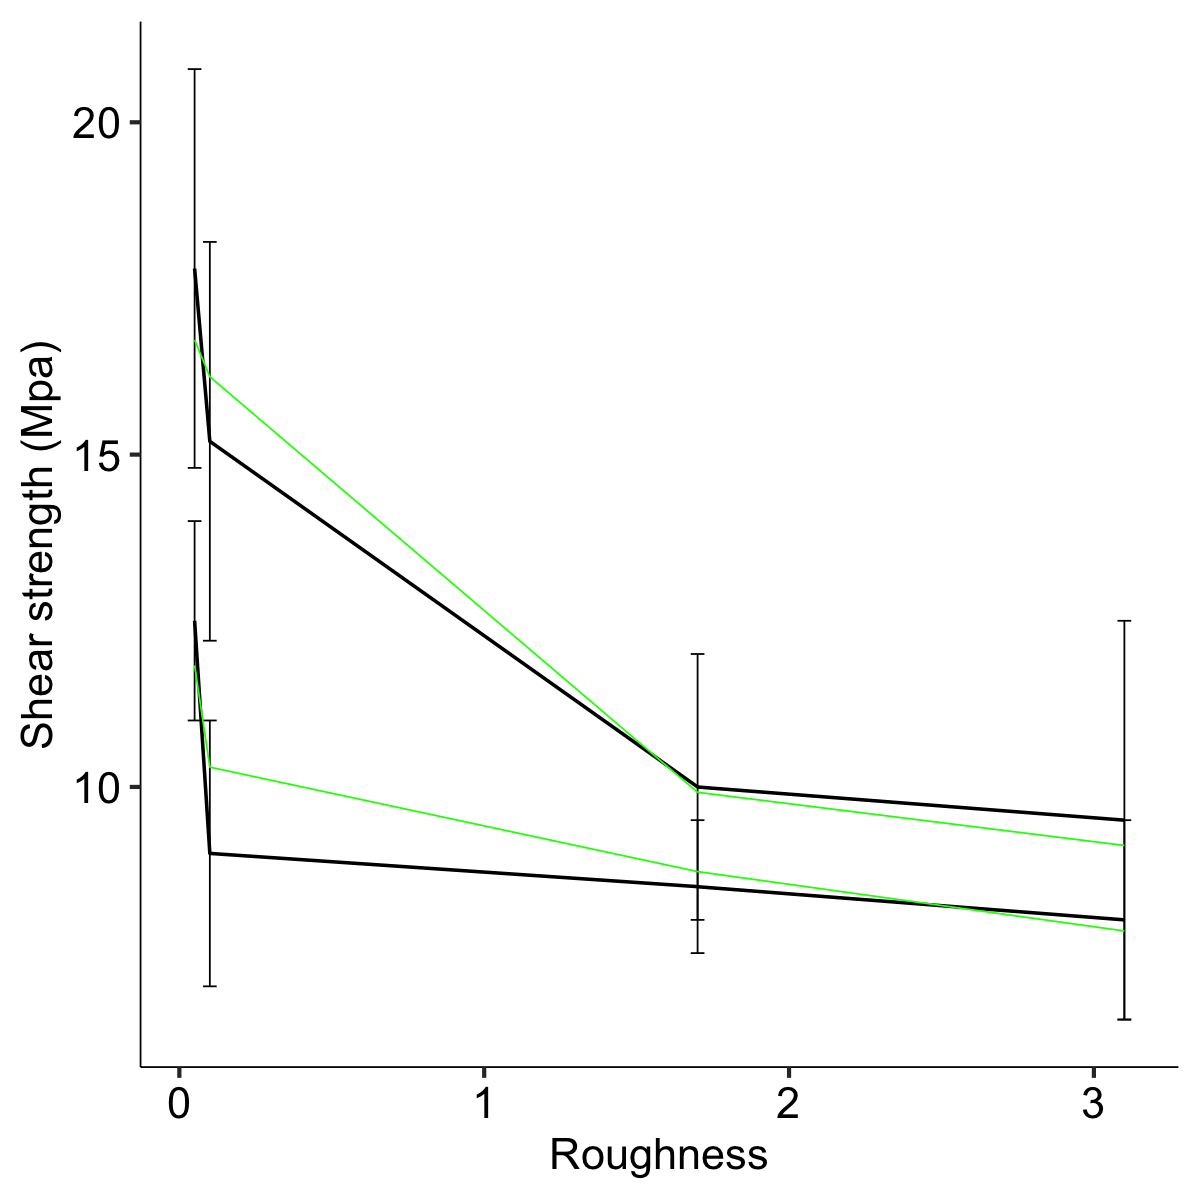

In [6]:
prior1 <- prior(normal(1, 0.1), class = "sigma") +
          prior(normal(10, 3), nlpar = "alpha0", lb=0) +
          prior(normal(0, 0.1), nlpar = "alpha0d", lb=0) +
          prior(normal(0, 0.1), nlpar = "alpha0dd") +
          prior(normal(2, 2), nlpar = "alpha1") +
#           prior(normal(0, 0.1), nlpar = "alpha1d") +
          prior(normal(-1, 1), nlpar = "alpha2",ub=0) +
            prior(normal(0, 0.1), nlpar = "alpha2d") 
fit <- brm(
        bf(shearStrength ~ ((alpha0 + alpha0d * pressure+ alpha0dd * pressure * roughness) + 
                            exp( (alpha1) + 
                            (alpha2 + alpha2d * pressure) * pow(roughness,1))),
        alpha0 + alpha0d + alpha0dd + alpha1 + alpha2 + alpha2d ~ 1, 
        nl = TRUE),
        data = df, 
        prior=prior1,
        iter=2000,
        chains = 2,
        cores = 2,
        seed = 8888,
        control = list(adapt_delta = 0.9),
        refresh = 0
)
pairs(fit)

preds=cbind(predict(fit,newdata=df),df)
preds

ggplot(data=preds) + geom_line(aes(x=roughness,y=shearStrength,group=pressure),size=1)+
    geom_errorbar(aes(x=roughness, ymin=shearStrengthL, ymax=shearStrengthU))+
    xlab("Roughness")+ ylab("Shear strength (Mpa)")+
    theme_pubr(26) +
    geom_line(aes(x=roughness, y=Estimate,group=pressure),col="Green")

From an aesthetic perspective, model three at least looks the best. What is theoretically most justified, not sure.

In [175]:
25/2

[1] 12.5

In [177]:
pred_df1 = data.frame(roughness=seq(0.00,5,0.05),pressure=rep(0,length(seq(0.00,5,0.05))))
preds1 = cbind(pred_df1,predict(fit,newdata=pred_df1,probs=c(0.05,0.125,0.25,0.375,0.675,0.75,0.875,0.95)))
preds1$key = "0Pa"

pred_df2 = data.frame(roughness=seq(0.00,5,0.05),pressure=rep(300,length(seq(0.00,5,0.05))))
preds2 = cbind(pred_df2,predict(fit,newdata=pred_df2,probs=c(0.05,0.125,0.25,0.375,0.675,0.75,0.875,0.95)))
preds2$key = "300Pa"

preds = rbind(preds1,preds2)

head(preds)
tail(preds)

roughness pressure Estimate Est.Error Q5       Q12.5    Q25      Q37.5   
1 0.00      0        17.35806 1.370184  15.08703 15.83657 16.48150 16.94245
2 0.05      0        16.76114 1.251474  14.74007 15.34533 15.90451 16.34676
3 0.10      0        16.17698 1.258747  14.14921 14.79015 15.35453 15.76413
4 0.15      0        15.67438 1.283584  13.61677 14.23470 14.82122 15.26684
5 0.20      0        15.14505 1.257600  13.11507 13.69549 14.27383 14.73425
6 0.25      0        14.71136 1.265487  12.69254 13.28370 13.86217 14.28009
  Q67.5    Q75      Q87.5    Q95      key
1 17.95100 18.26192 18.90947 19.63147 0Pa
2 17.32232 17.62776 18.22768 18.77449 0Pa
3 16.68876 17.01113 17.56572 18.30153 0Pa
4 16.22474 16.49637 17.12497 17.81009 0Pa
5 15.71071 15.98974 16.56644 17.20332 0Pa
6 15.30648 15.64432 16.22213 16.77425 0Pa

roughness pressure Estimate Est.Error Q5       Q12.5    Q25      Q37.5   
197 4.75      300      6.864253 1.823758  3.869742 4.778011 5.635921 6.258045
198 4.80      300      6.830523 1.882363  3.736259 4.648946 5.596905 6.254490
199 4.85      300      6.822900 1.920139  3.733410 4.633833 5.542866 6.218226
200 4.90      300      6.748129 1.897060  3.646659 4.551504 5.501263 6.121032
201 4.95      300      6.756693 1.874752  3.737057 4.637836 5.520591 6.129211
202 5.00      300      6.662388 1.907911  3.584072 4.515479 5.314245 6.038646
    Q67.5    Q75      Q87.5    Q95      key  
197 7.720529 8.105001 8.961983 9.919264 300Pa
198 7.666666 8.117968 8.962534 9.941831 300Pa
199 7.707247 8.099189 9.031011 9.936944 300Pa
200 7.634980 8.048294 8.938913 9.920977 300Pa
201 7.604224 8.012283 8.897981 9.933090 300Pa
202 7.557287 7.974395 8.859303 9.801035 300Pa

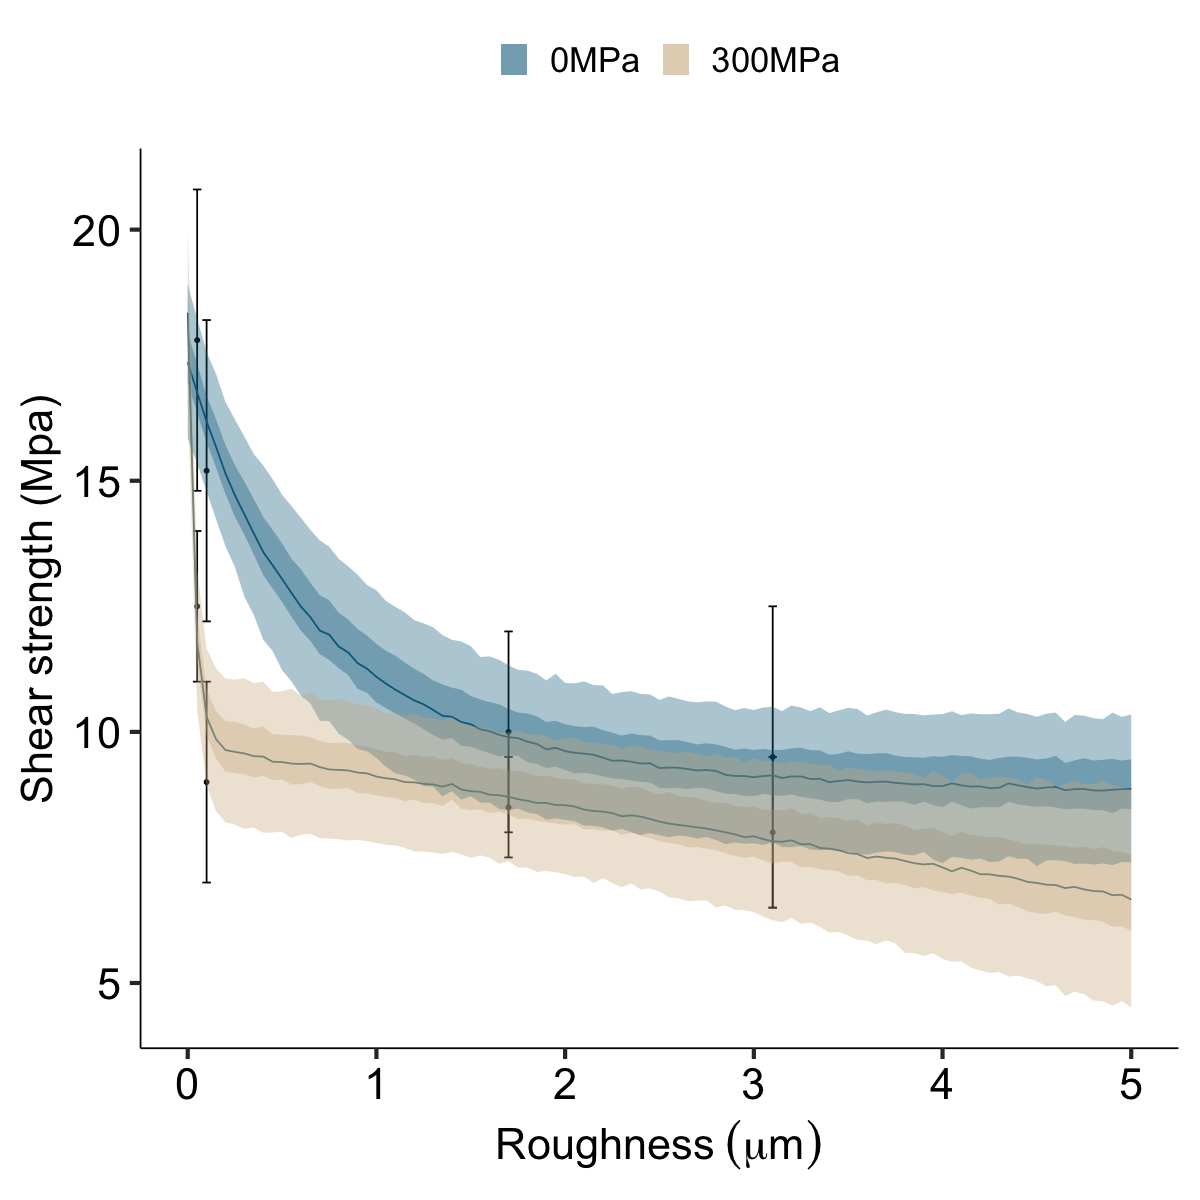

In [187]:
ggplot(data=df) + geom_point(aes(x=roughness,y=shearStrength,group=pressure),size=1)+
    geom_errorbar(aes(x=roughness, ymin=shearStrengthL, ymax=shearStrengthU))+
    xlab(expression(Roughness ~ (mu*m)))+ ylab("Shear strength (Mpa)")+
    theme_pubr(26) +
    geom_line(data = preds , aes(x=roughness, y=Estimate,group=pressure),col="Deepskyblue4") + 
    geom_ribbon(data = preds, aes(x = roughness, ymin = Q37.5, ymax = Q67.5, fill = key)) +
#     geom_ribbon(data = preds, aes(x = roughness, ymin = Q5, ymax = Q95, fill = key)) +
    geom_ribbon(data = preds, aes(x = roughness, ymin = Q12.5, ymax = Q87.5, fill = key)) +
#     geom_ribbon(data = preds, aes(x = roughness, ymin = Q5, ymax = Q95, fill = key)) +
     scale_fill_manual(name = "", labels = c("0MPa","300MPa"),values = c(alpha("Deepskyblue4",0.35),
                                                                     alpha("Tan",0.35)))

In [180]:
basis = data.frame(roughness=seq(0.00,5,0.05),pressure=seq(0.00,5,0.05))
expanded_pred_df = basis %>% expand(roughness,pressure)
preds2 = cbind(expanded_pred_df,predict(fit,newdata=expanded_pred_df,probs=c(0.05,0.25,0.75,0.95)))
colnames(preds2)[3] <- "Shear Strength MPa"
head(preds2)

roughness pressure Shear Strength MPa Est.Error Q5       Q25      Q75     
1 0         0.00     17.34677           1.355816  15.10917 16.42058 18.23082
2 0         0.05     17.39305           1.387076  15.16246 16.43084 18.32399
3 0         0.10     17.36605           1.359472  15.17133 16.44483 18.25818
4 0         0.15     17.40239           1.368236  15.28378 16.46262 18.28975
5 0         0.20     17.39327           1.381103  15.12874 16.43378 18.28338
6 0         0.25     17.33801           1.365988  15.08495 16.42284 18.27087
  Q95     
1 19.65587
2 19.76322
3 19.63601
4 19.75175
5 19.66665
6 19.54781

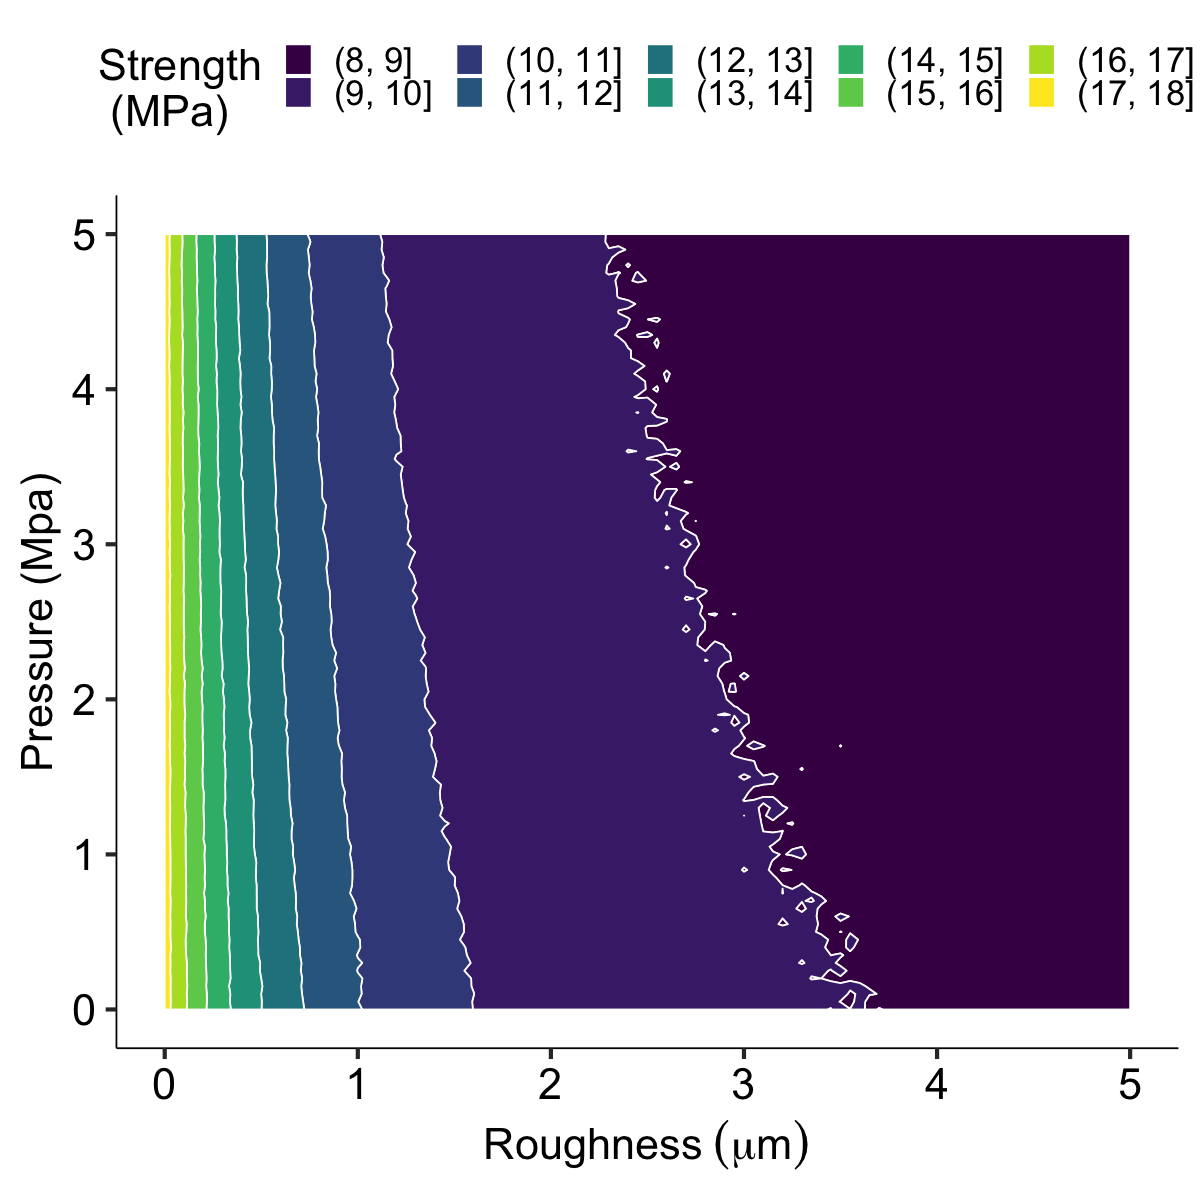

In [181]:
ggplot(data = preds2) +
    geom_contour_filled(aes(x=roughness, y=pressure, z=`Shear Strength MPa`),colour = "white") + 
    xlab(expression(Roughness ~ (mu*m)))+ ylab("Pressure (Mpa)")+
    guides(fill=guide_legend(title="Strength\n (MPa)"))+
#     scale_fill_(name=`Shear Strength MPa`) +
#     scale_fill_discrete(name = `Shear Strength MPa`)+
    theme_pubr(26) 